In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt

Tlist = [1.0]
from matplotlib.pyplot import cm
clist = [cm.get_cmap("gnuplot")(float(i)/float(len(Tlist))) for i in range(len(Tlist))]
font={'family':'serif',
      # 'style':'italic',  # 斜体
      'weight':'normal',
      # 'color':'red',
      'size': 18
}

/tmp/ipykernel_688420/1561577914.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  clist = [cm.get_cmap("gnuplot")(float(i)/float(len(Tlist))) for i in range(len(Tlist))]


In [2]:
def read_kernel_33(dirname):
    filename = os.path.join(dirname, "s0-Sk-33-real.dat")
    with open(filename,"r") as fp:
        fp.readline()
        s011,covs011 = tuple([float(x) for x in fp.readline().split()[1:]])
    return s011, covs011

def read_kernel(dirname, elempair):
    filename = os.path.join(dirname, "s0-Sk-"+elempair+"-real.dat")
    with open(filename,"r") as fp:
        fp.readline()
        s011,covs011 = tuple([float(x) for x in fp.readline().split()[1:]])
    return s011, covs011

def read_kernel_22(dirname):
    filename = os.path.join(dirname, "s0-Sk-22-real.dat")
    with open(filename,"r") as fp:
        fp.readline()
        s011,covs011 = tuple([float(x) for x in fp.readline().split()[1:]])
    return s011, covs011

In [3]:
def read_lammpstrj(filedesc):
    # three comment lines
    for i in range(3): comment = filedesc.readline()
    # number of atoms
    natoms = int(filedesc.readline())

    # 1 comment line
    comment = filedesc.readline()
    # assume orthorombic cell
    cell = np.zeros(3,float)
    for i in range(3):
        # [cellmin, cellmax] = filedesc.readline().split()
        linec = filedesc.readline().split()
        cellmin = linec[0]
        cellmax = linec[1]
        cell[i] = float(cellmax) - float(cellmin)

    # 1 comment line
    comment = filedesc.readline()
    names = np.zeros(natoms,'U2')
    q = np.zeros((natoms,3),float)
    sq = np.zeros((natoms,3),float)

    for i in range(natoms):
        line = filedesc.readline().split();
        names[i] = line[1] # atom type
        q[i] = line[2:5] # wrapped atomic coordinates
        sq[i,0] = float(q[i,0])/cell[0] # scaled atomic coordinates
        sq[i,1] = float(q[i,1])/cell[1] # scaled atomic coordinates
        sq[i,2] = float(q[i,2])/cell[2] # scaled atomic coordinates
    return [cell, names, sq]

In [4]:
import numpy as np
import torch
from torch.autograd.functional import jacobian
from torch.autograd.functional import hessian

In [5]:
def cofactor(B):
    return (np.linalg.inv(B)).T * np.linalg.det(B)


In [6]:
def fillDmat(x, Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Dmat = np.eye(rank)
    for i in range(rank):
        for j in range(rank):
            if i != j:
                Dmat[i][j] += np.sqrt(x[j]/x[i])*(Smat[i][j])
            else:
                Dmat[i][j] += np.sqrt(x[j]/x[i])*(Smat[i][j]-1)
    return Dmat

def fillDmat_(x, Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Dmat = torch.eye(rank).to(torch.float64)
    for i in range(rank):
        for j in range(rank):
            if i != j:
                Dmat[i][j] += torch.sqrt(x[j]/x[i])*(Smat[i][j])
            else:
                Dmat[i][j] += torch.sqrt(x[j]/x[i])*(Smat[i][j]-1)
    return Dmat

In [7]:
def fillapproxGmat(Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Gmat = Smat/0.04-np.eye(rank,rank)/0.04
    return Gmat

def fillapproxGmat_(Smat):
    assert Smat.shape[0] == Smat.shape[1] and len(Smat.shape) == 2
    rank = Smat.shape[0]  
    Gmat = Smat/0.04-torch.eye(rank,rank).to(torch.float64)/0.04
    return Gmat

In [25]:
def KBI_mu(x_, Smat_, elem=0):
    rank = x_.shape[0]
    Smat_ = Smat_.reshape(rank, rank)
    approx_Gmat = fillapproxGmat_(Smat_)
    print("            Smat = ")
    print(Smat_.detach().numpy())
    # print("Approximate Gmat = ", approx_Gmat[0,0], approx_Gmat[1,1], approx_Gmat[0,1], approx_Gmat[1,0])
    # Smat_ = torch.from_numpy(Smat).requires_grad_()
    
    # Gmat = fillGmat(c, Smat)
    # Bmat = fillBmat(c, Gmat)
    # Dmat = fillDmat(x,Smat)
    Dmat_ = fillDmat_(x_,Smat_)
    # tiDmat = np.linalg.inv(Dmat).T
    tiDmat_ = torch.linalg.inv(Dmat_).T
    # Kai_NPT = np.zeros([rank,rank])
    Kai_NPT_ = torch.zeros([rank,rank], dtype=torch.float64)
    # x_ = torch.from_numpy(x).requires_grad_()
    for i in range(rank):
        for j in range(rank):
            s1 = 0.0
            s2 = 0.0
            s3 = 0.0
            for k in range(rank):
                s1 += tiDmat_[k][i]
                s2 += tiDmat_[k][j]
                for h in range(rank):
                    s3 += x_[h]*tiDmat_[k][h]
            Kai_NPT_[i][j] = tiDmat_[i][j]/x_[i] - s1*s2/s3
    print("Kai_NPT_N*V     = ",Kai_NPT_)
    Kai_NPT_lnx_ = torch.zeros(rank).to(torch.float64)
    for i in range(rank):
        for j in range(rank):
            if i==j: 
                Kai_NPT_lnx_[i] += Kai_NPT_[i][i]*x_[i]
            else:
                Kai_NPT_lnx_[i] -= Kai_NPT_[i][j]*x_[i]
    # print("Kai_NPT_lnx = ", Kai_NPT_lnx_)
    
    # Kai_NPT_00_a = 1./(x_[1]*Smat_[0][0]+x_[0]*Smat_[1][1]-2*torch.sqrt(x_[0]*x_[1])*Smat_[0][1])  
    # print("!!!!!! checking:: ", (x_[1]*Smat_[0][0]+x_[0]*Smat_[1][1]-2*torch.sqrt(x_[0]*x_[1])*Smat_[0][1]), Kai_NPT_00_a) 
    # assert math.isclose(Kai_NPT_lnx_[0].detach().numpy(), Kai_NPT_00_a.detach().numpy(), abs_tol =  1e-4)
    return Kai_NPT_lnx_[elem]

In [9]:
frac_1 = 0.10
frac_2 = np.arange(0.05, 0.90, 0.05)
frac_3 = 1-frac_1-frac_2
molfrac_list=[[frac_1, frac_2[i], frac_3[i]] for i in range(len(frac_2))]
print(molfrac_list)


[[0.1, 0.05, 0.85], [0.1, 0.1, 0.8], [0.1, 0.15000000000000002, 0.75], [0.1, 0.2, 0.7], [0.1, 0.25, 0.65], [0.1, 0.3, 0.6000000000000001], [0.1, 0.35000000000000003, 0.55], [0.1, 0.4, 0.5], [0.1, 0.45, 0.45], [0.1, 0.5, 0.4], [0.1, 0.55, 0.35], [0.1, 0.6000000000000001, 0.29999999999999993], [0.1, 0.6500000000000001, 0.2499999999999999], [0.1, 0.7000000000000001, 0.19999999999999996], [0.1, 0.7500000000000001, 0.1499999999999999], [0.1, 0.8, 0.09999999999999998], [0.1, 0.8500000000000001, 0.04999999999999993]]


In [26]:
Kai_NPT_lnx_list = []
Kai_NPT_lnx1_list = []
std_Kai_NPT_lnx_list = []
# order2_std_Kai_NPT_lnx_list = []
s0_list = []

for idx_T, T in enumerate(Tlist):
    Kai_NPT_lnx_list.append([])
    Kai_NPT_lnx1_list.append([])
    std_Kai_NPT_lnx_list.append([])
    s0_list.append([])

    for idx_molfrac_, molfrac_ in enumerate(molfrac_list):
        dirname = "A%.2fB%.2f/"%(molfrac_list[idx_molfrac_][0], molfrac_list[idx_molfrac_][1])
        s011, cov_s011 = read_kernel(dirname, "11")
        s012, cov_s012 = read_kernel(dirname, "12")
        s022, cov_s022 = read_kernel(dirname, "22")
        s013, cov_s013 = read_kernel(dirname, "13")
        s023, cov_s023 = read_kernel(dirname, "23")
        s033, cov_s033 = read_kernel(dirname, "33")




        x = molfrac_
        print("Mole fraction of atoms in the system =",x)


        Smat = np.array([[s011, s012, s013], [s012, s022, s023], [s013, s023, s033]])
        s0_list[-1].append(Smat)
        std_Smat = np.sqrt(np.array([cov_s011, cov_s012, cov_s013, cov_s012, cov_s022, cov_s023, cov_s013, cov_s023, cov_s033]))
        # print("   std_Smat = ", std_Smat)
        varmat_Smat = np.outer(std_Smat, std_Smat)
        # print("varmat_Smat = ")
        # print(varmat_Smat)

        Smat_ = torch.from_numpy(Smat.reshape(-1)).to(dtype=torch.float64).requires_grad_()
        x_ = torch.tensor(x).to(torch.float64).requires_grad_(False)
        
        Kai_NPT_lnx_0 = KBI_mu(x_, Smat_, 1)
        Kai_NPT_lnx_1 = KBI_mu(x_, Smat_, 2)
        print("Kai_NPT_lnx = ", Kai_NPT_lnx_0, Kai_NPT_lnx_1)
        jac = jacobian(KBI_mu, (x_, Smat_.reshape(-1)))[1]
        # print("Jac = ")
        # print(jac)
        varmat_Smat_ = torch.from_numpy(varmat_Smat)
        varmat_KaiNPT_lnx = torch.matmul(torch.matmul(jac, varmat_Smat_), jac.T)
        
        # print("          var_KaiNPT_lnx = ", varmat_KaiNPT_lnx)
        # print("2nd order var_KaiNPT_lnx = ", order2_varmat_KaiNPT_lnx)
        std_KaiNPT_lnx = torch.sqrt(varmat_KaiNPT_lnx)
        # print("          std_KaiNPT_lnx = ", std_KaiNPT_lnx)
        Kai_NPT_lnx_list[-1].append(Kai_NPT_lnx_0.detach().numpy())
        Kai_NPT_lnx1_list[-1].append(Kai_NPT_lnx_1.detach().numpy())
        std_Kai_NPT_lnx_list[-1].append(std_KaiNPT_lnx.detach().numpy())
        print("\n")
        

Mole fraction of atoms in the system = [0.1  0.05 0.85]
            Smat = 
[[ 0.91210716 -0.07134526 -0.28642719]
 [-0.07134526  0.94385588 -0.19208611]
 [-0.28642719 -0.19208611  0.1625302 ]]
Kai_NPT_N*V     =  tensor([[ 8.9129, -0.9337, -0.9936],
        [-0.9337, 19.2075, -1.0200],
        [-0.9936, -1.0200,  0.1769]], dtype=torch.float64,
       grad_fn=<CopySlices>)
            Smat = 
[[ 0.91210716 -0.07134526 -0.28642719]
 [-0.07134526  0.94385588 -0.19208611]
 [-0.28642719 -0.19208611  0.1625302 ]]
Kai_NPT_N*V     =  tensor([[ 8.9129, -0.9337, -0.9936],
        [-0.9337, 19.2075, -1.0200],
        [-0.9936, -1.0200,  0.1769]], dtype=torch.float64,
       grad_fn=<CopySlices>)
Kai_NPT_lnx =  tensor(1.0581, dtype=torch.float64, grad_fn=<SelectBackward0>) tensor(1.8620, dtype=torch.float64, grad_fn=<SelectBackward0>)
            Smat = 
[[ 0.91210716 -0.07134526 -0.28642719]
 [-0.07134526  0.94385588 -0.19208611]
 [-0.28642719 -0.19208611  0.1625302 ]]
Kai_NPT_N*V     =  tensor([

(1, 17, 3, 3)


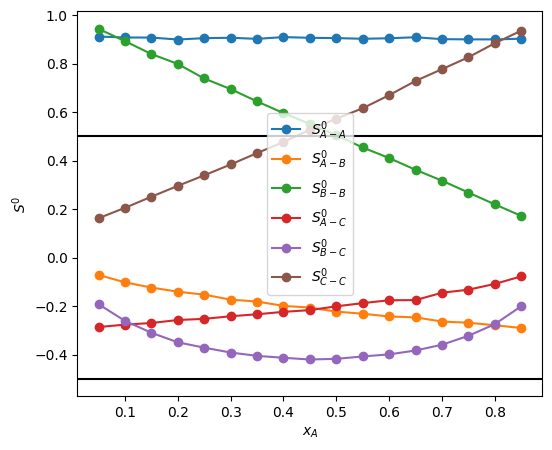

In [11]:
xlist = []
for idx_molfrac_, molfrac_ in enumerate(molfrac_list):
    xlist.append(molfrac_[1])

s0_list = np.array(s0_list)
print(s0_list.shape)

plt.rcParams["figure.figsize"] = (6,5)
plt.plot(xlist, s0_list[0,:,0,0], marker="o", label="$S^0_{A-A}$")
plt.plot(xlist, s0_list[0,:,0,1], marker="o", label="$S^0_{A-B}$")
plt.plot(xlist, s0_list[0,:,1,1], marker="o", label="$S^0_{B-B}$")
plt.plot(xlist, s0_list[0,:,0,2], marker="o", label="$S^0_{A-C}$")
plt.plot(xlist, s0_list[0,:,1,2], marker="o", label="$S^0_{B-C}$")
plt.plot(xlist, s0_list[0,:,2,2], marker="o", label="$S^0_{C-C}$")
plt.axhline(0.5, c="k")
plt.axhline(-0.5, c="k")
plt.xlabel("$x_A$")
plt.ylabel("$S^0$")
plt.legend()

In [12]:
Kai_NPT_lnx_list[0] = np.array(Kai_NPT_lnx_list[0])
Kai_NPT_lnx1_list[0] = np.array(Kai_NPT_lnx1_list[0])
print(Kai_NPT_lnx_list[0].shape)
'''
import dpdata

totalatom = 23328
c_A_list = []
c_B_list = []
N_A_list = []
N_B_list = []
Tlist = [1.]
Volume_list = []
for idx_T, T in enumerate(Tlist):
    c_A_list.append([])
    c_B_list.append([])
    Volume_list.append([])
    for idx_molfrac_, molfrac_ in enumerate(molfrac_list):
        molfrac_1 = molfrac_[0]
        dirname = "binary/frac%.2f/"%(molfrac_1)
        filename = os.path.join(dirname, "thermo-lammps.dat")
        Volume_data = np.loadtxt(filename, skiprows=10007).T[6]
        Volume = np.mean(Volume_data)
        Volume_list[-1].append(Volume)
        conf = dpdata.System(os.path.join(dirname, "data.lj"), "lammps/lmp")
        N_A_list.append(conf["atom_numbs"][0])
        N_B_list.append(conf["atom_numbs"][1])
        c_A = conf["atom_numbs"][0]/Volume
        c_A_list[-1].append(c_A)
        c_B = conf["atom_numbs"][1]/Volume
        c_B_list[-1].append(c_B)

        
        print(int(np.ceil(totalatom*molfrac_1)), conf["atom_numbs"][0])
        # assert int(np.ceil(totalatom*molfrac_1)) == conf["atom_numbs"][0]
        # assert int(totalatom-np.ceil(totalatom*molfrac_1)) == conf["atom_numbs"][1]
c_A_list = np.array(c_A_list)
c_B_list = np.array(c_B_list)
Volume_list = np.array(Volume_list)
N_A_list = np.array(N_A_list)
N_B_list = np.array(N_B_list)

print(c_A_list)
print(c_B_list)
print(totalatom)
assert np.allclose(c_A_list+c_B_list, totalatom/Volume_list)
'''

(17,)


'\nimport dpdata\n\ntotalatom = 23328\nc_A_list = []\nc_B_list = []\nN_A_list = []\nN_B_list = []\nTlist = [1.]\nVolume_list = []\nfor idx_T, T in enumerate(Tlist):\n    c_A_list.append([])\n    c_B_list.append([])\n    Volume_list.append([])\n    for idx_molfrac_, molfrac_ in enumerate(molfrac_list):\n        molfrac_1 = molfrac_[0]\n        dirname = "binary/frac%.2f/"%(molfrac_1)\n        filename = os.path.join(dirname, "thermo-lammps.dat")\n        Volume_data = np.loadtxt(filename, skiprows=10007).T[6]\n        Volume = np.mean(Volume_data)\n        Volume_list[-1].append(Volume)\n        conf = dpdata.System(os.path.join(dirname, "data.lj"), "lammps/lmp")\n        N_A_list.append(conf["atom_numbs"][0])\n        N_B_list.append(conf["atom_numbs"][1])\n        c_A = conf["atom_numbs"][0]/Volume\n        c_A_list[-1].append(c_A)\n        c_B = conf["atom_numbs"][1]/Volume\n        c_B_list[-1].append(c_B)\n\n        \n        print(int(np.ceil(totalatom*molfrac_1)), conf["atom_numb

In [13]:
molfrac_list = np.array(molfrac_list)

x = np.array(molfrac_list[:,1])
lnx = np.log(x).reshape(-1,1)
# lnc = np.log(c_A_list).reshape(-1,1)
x1 = molfrac_list[:,2]
lnx1 = np.log(x1).reshape(-1,1)
# lnc1 = np.log(c_B_list).reshape(-1,1)
# plt.plot(x, Volume_list[0])


In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
from scipy.integrate import quad
# kernel = 1.0 * RBF(length_scale=0.005, length_scale_bounds="fixed")
kernel = 1.0 * RBF(length_scale=1) +ConstantKernel()
gp = GaussianProcessRegressor(kernel=kernel)

gp.fit(lnx.reshape(-1,1), Kai_NPT_lnx_list[0].reshape(-1,1))
y_gp, std_y_gp = gp.predict(lnx.reshape(-1,1), return_std=True)



kernel = 1.0 * RBF(length_scale=1) +ConstantKernel()
gp1 = GaussianProcessRegressor(kernel=kernel)
gp1.fit(lnx1.reshape(-1,1), Kai_NPT_lnx1_list[0].reshape(-1,1))
y_gp1, std_y_gp1 = gp1.predict(lnx1.reshape(-1,1), return_std=True)

/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


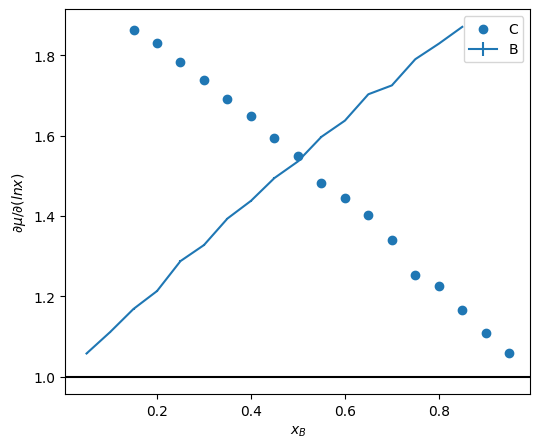

In [15]:
plt.rcParams["figure.figsize"] = (6,5)

# plt.scatter(x, Kai_NPT_lnx_list[0], marker="o", label="A")
# plt.scatter(x, y_gp, marker="*", label="A")
# plt.fill_between(x, y_gp+std_y_gp, y_gp-std_y_gp, label="A")
plt.errorbar(x, Kai_NPT_lnx_list[0], std_Kai_NPT_lnx_list[0], label="B")
plt.scatter(1-x1, Kai_NPT_lnx1_list[0], marker="o", label="C")
# plt.scatter(1-x1, y_gp1, marker="x", label="B")

plt.xlabel("$x_B$")
plt.ylabel("$\partial \mu/\partial (lnx) $")
plt.legend()
plt.axhline(1, c="k")


In [16]:
plt.rcParams["figure.figsize"] = (6,5)
from scipy.integrate import trapz
lnx1 = lnx1.reshape(-1)
lnx = lnx.reshape(-1)


integral_gp = np.cumsum([0]+[(y_gp[i]+y_gp[i+1])/2*(lnx[i+1]-lnx[i]) for i in range(len(lnx)-2)])
integral_gp1 = np.cumsum([0]+[(y_gp1[i]+y_gp1[i+1])/2*(lnx1[i+1]-lnx1[i]) for i in range(len(lnx1)-2)])
print("x-variable::")
print(x)
print(x1)
print("lnx-variable::")
print(lnx)
print(lnx1)
print("Integrand:: ")
print(y_gp)
print(y_gp1)
print("Integral cumsum")
print(integral_gp)
print(integral_gp1)

baseline = -np.array([lnx[i]-lnx[0] for i in range(len(lnx)-1)])
baseline1 = -np.array([lnx1[i]-lnx1[0] for i in range(len(lnx1)-1)])


print("baseline")
print(baseline)
print(baseline1)

print("excess")
print((integral_gp+baseline))
print((integral_gp1+baseline1))


x-variable::
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85]
[0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35 0.3  0.25 0.2
 0.15 0.1  0.05]
lnx-variable::
[-2.99573227 -2.30258509 -1.89711998 -1.60943791 -1.38629436 -1.2039728
 -1.04982212 -0.91629073 -0.7985077  -0.69314718 -0.597837   -0.51082562
 -0.43078292 -0.35667494 -0.28768207 -0.22314355 -0.16251893]
[-0.16251893 -0.22314355 -0.28768207 -0.35667494 -0.43078292 -0.51082562
 -0.597837   -0.69314718 -0.7985077  -0.91629073 -1.04982212 -1.2039728
 -1.38629436 -1.60943791 -1.89711998 -2.30258509 -2.99573227]
Integrand:: 
[1.05805969 1.11115817 1.16894563 1.21341665 1.2880526  1.32791886
 1.39394029 1.43791605 1.4946991  1.53598589 1.59722789 1.6375304
 1.70323516 1.72524748 1.79051418 1.82903274 1.87100672]
[1.861966   1.82963458 1.78466752 1.73793607 1.69090164 1.6496656
 1.5955381  1.5495874  1.48271    1.4460637  1.40317861 1.34005946
 1.25391276 1.2252605  1.16618927 1.10957605 1.0

[[array(0.00045483), array(0.00117321), array(0.00175844), array(0.00177076), array(0.00203688), array(0.00205198), array(0.0019767), array(0.00200415), array(0.00190123), array(0.00205025), array(0.00197149), array(0.00199503), array(0.00185025), array(0.00186462), array(0.00148244), array(0.00105436), array(5.02164625e-05)]]


/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


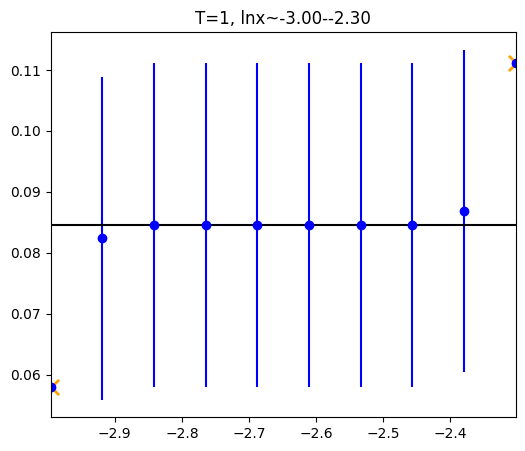

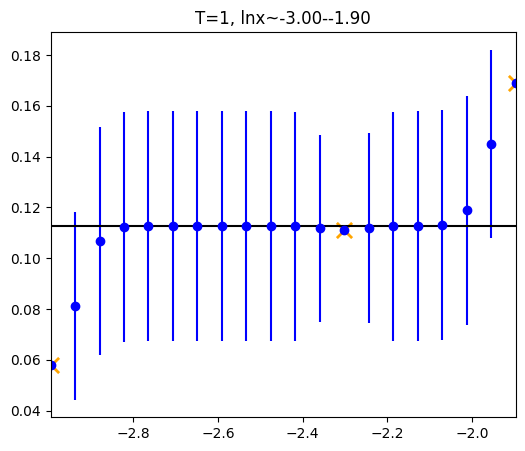

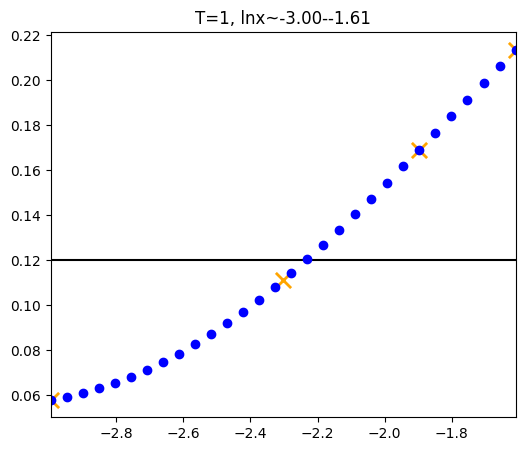

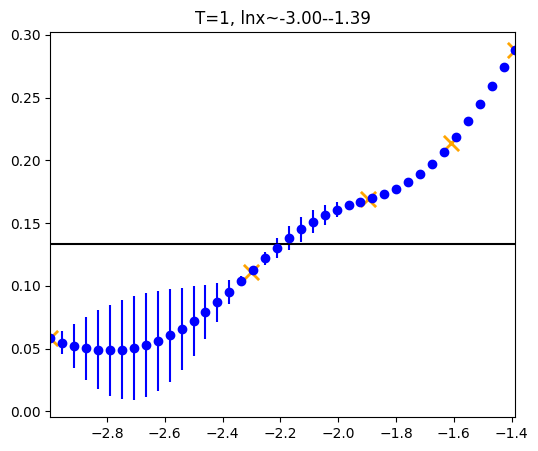

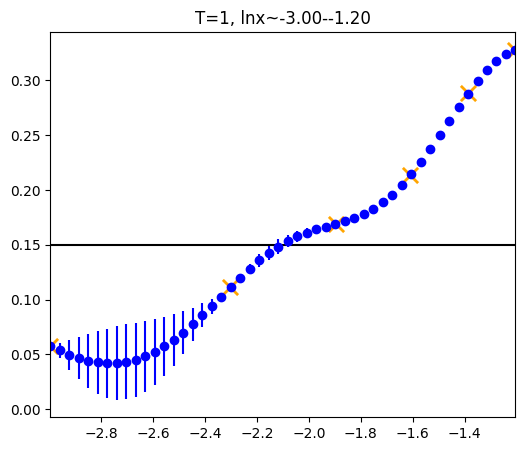

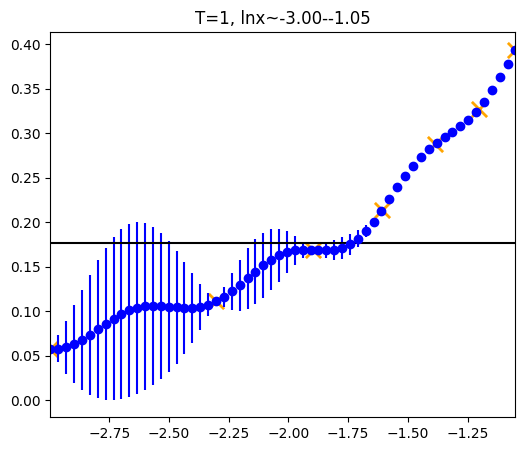

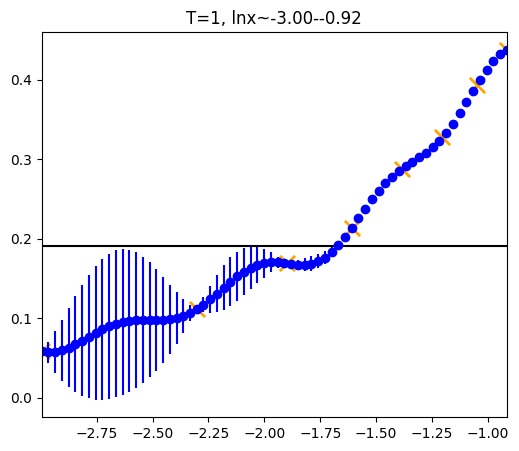

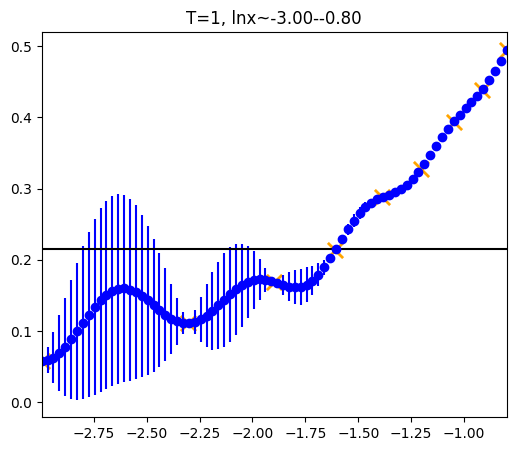

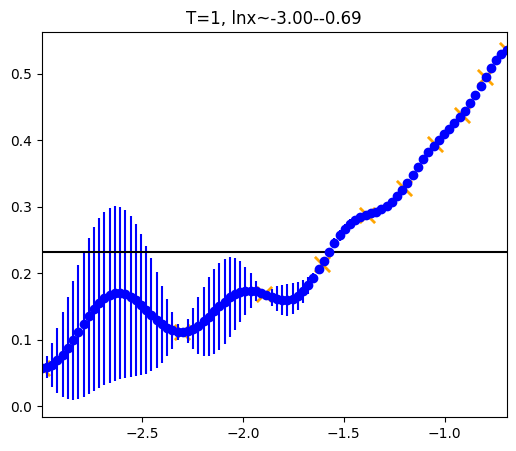

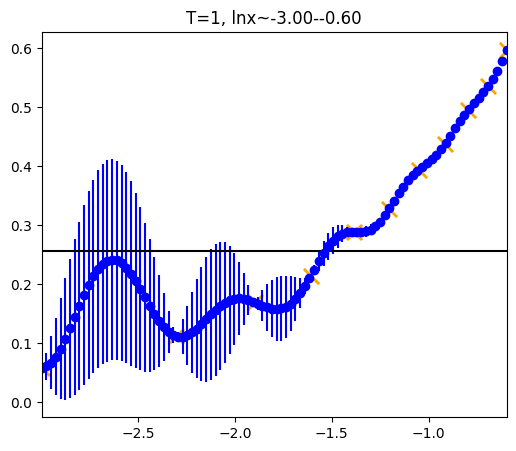

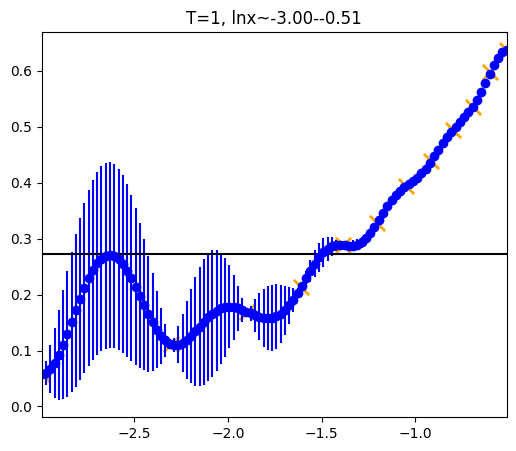

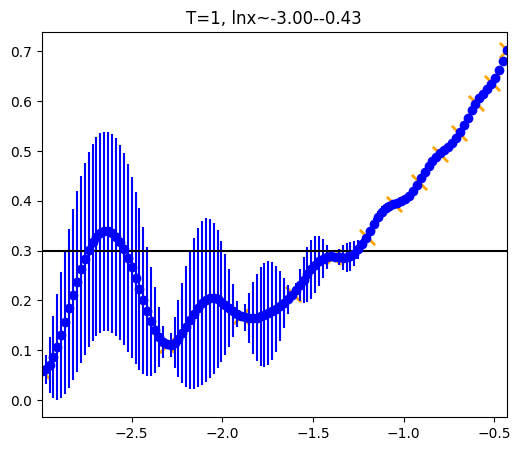

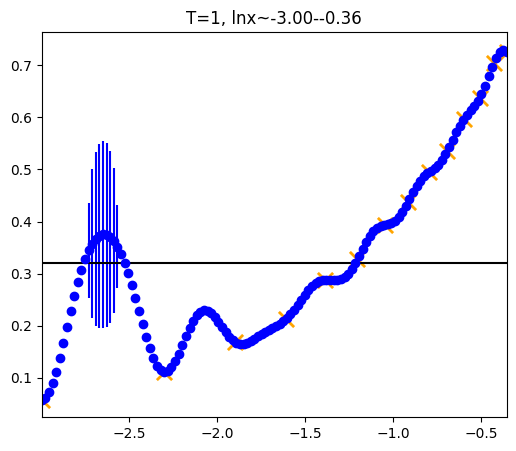

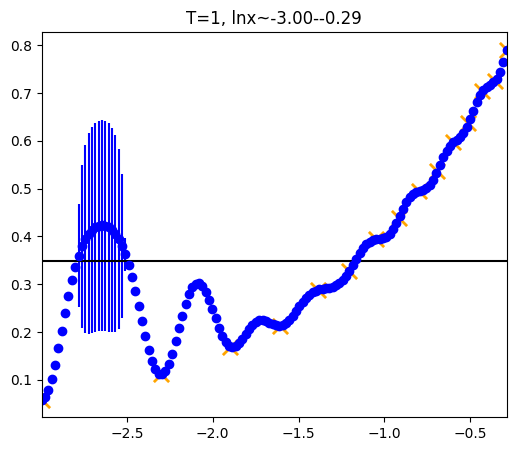

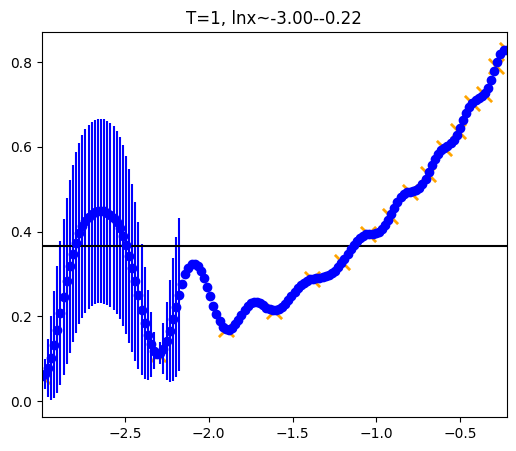

In [17]:
# integral by MC

lnx = lnx.reshape(-1)
MCintegral_gp = [0]
MCintegral_gp_std = [0]
print(std_Kai_NPT_lnx_list)

for i in range(len(lnx)-2):
    min_lnx = lnx[0]
    max_lnx = lnx[i+1]
    area_lnx = (max_lnx-min_lnx)

    MC_x_samples = np.linspace(min_lnx, max_lnx, 10*(i+1))
    mean_Kai = np.mean(Kai_NPT_lnx_list[idx_T][:i+2])
    kernel = 1.0 * RBF(length_scale=0.05*np.abs(area_lnx))
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(lnx[:i+2].reshape(-1,1), Kai_NPT_lnx_list[idx_T][:i+2].reshape(-1,1)-mean_Kai)

    MC_y_samples, std_MC_y_samples = gp.predict(MC_x_samples.reshape(-1,1), return_std=True)
    MC_y_samples -= 1.
    MC_y_average = np.mean(MC_y_samples.reshape(-1))
    MC_y_std = max(np.max(std_MC_y_samples.reshape(-1)), std_Kai_NPT_lnx_list[0][i+1])/np.sqrt(100*(i+1))
    MCintegral_gp.append((MC_y_average+mean_Kai)*(area_lnx))
    # print(i, area_lnx, MC_y_average+mean_Kai)
    MCintegral_gp_std.append(MC_y_std*np.abs(area_lnx))
    plt.figure()
    plt.errorbar(np.linspace(min_lnx, max_lnx, 10*(i+1)), MC_y_samples+mean_Kai, std_MC_y_samples, c="blue", fmt='o', linestyle='None')
    plt.scatter(lnx[:i+2], Kai_NPT_lnx_list[idx_T][:i+2]-1, marker="x", c="orange", s=120, linewidths=2)
    plt.axhline(MC_y_average+mean_Kai, c="k")
    plt.xlim((min_lnx, max_lnx))
    plt.title("T=%d, lnx~%.2f-%.2f"%(T, min_lnx, max_lnx))

MCintegral_gp = np.array(MCintegral_gp)
MCintegral_gp_std = np.array(MCintegral_gp_std)



[0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35 0.3  0.25 0.2
 0.15 0.1  0.05]
[-0.16251893 -0.22314355 -0.28768207 -0.35667494 -0.43078292 -0.51082562
 -0.597837   -0.69314718 -0.7985077  -0.91629073 -1.04982212 -1.2039728
 -1.38629436 -1.60943791 -1.89711998 -2.30258509 -2.99573227]
[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85]
[-2.99573227 -2.30258509 -1.89711998 -1.60943791 -1.38629436 -1.2039728
 -1.04982212 -0.91629073 -0.7985077  -0.69314718 -0.597837   -0.51082562
 -0.43078292 -0.35667494 -0.28768207 -0.22314355 -0.16251893]


/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(
/nfs/scistore14/chenggrp/ptuo/pkgs/deepmd-kit/lib/python3.10/site-packages/sklearn/gaussian_process/_gpr.py:475: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn(


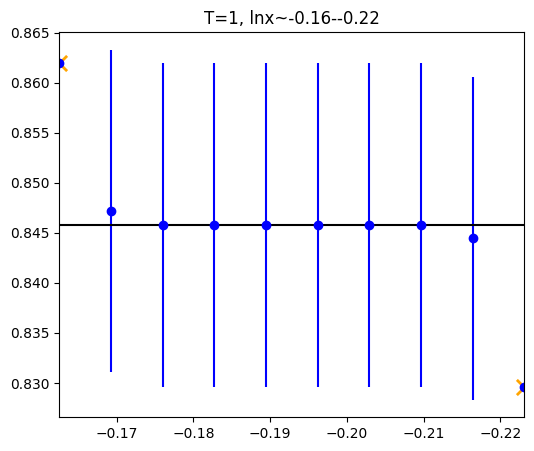

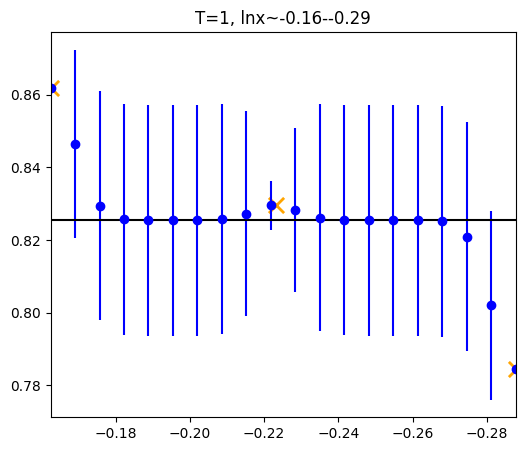

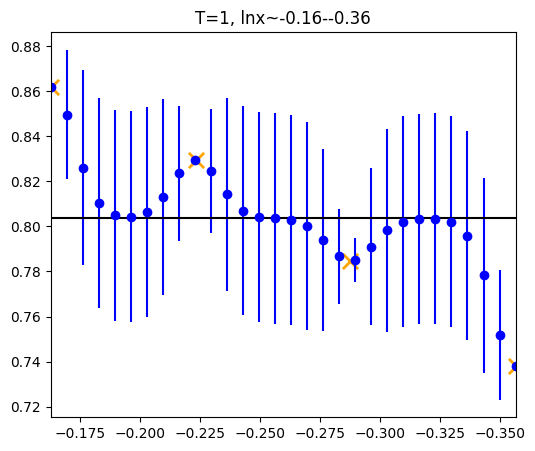

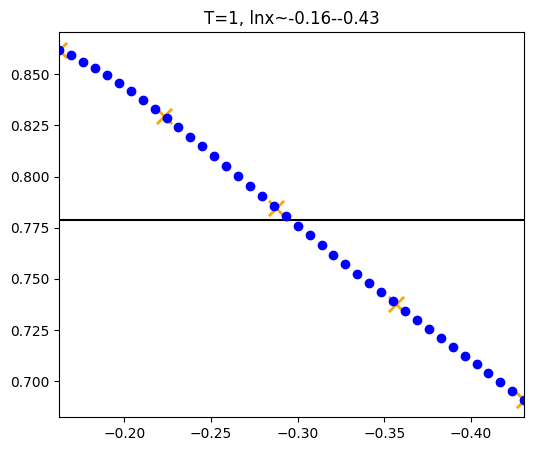

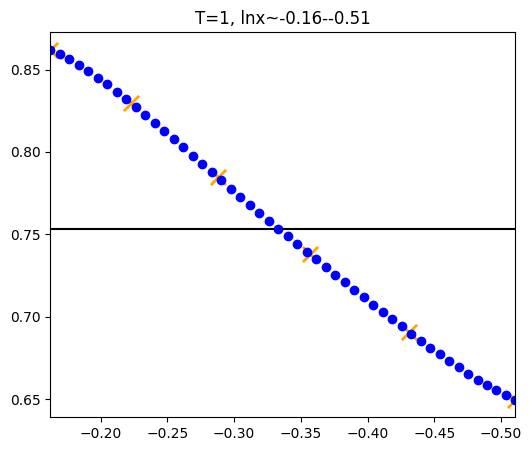

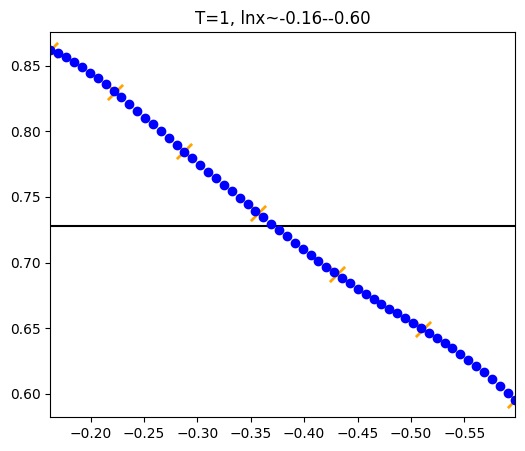

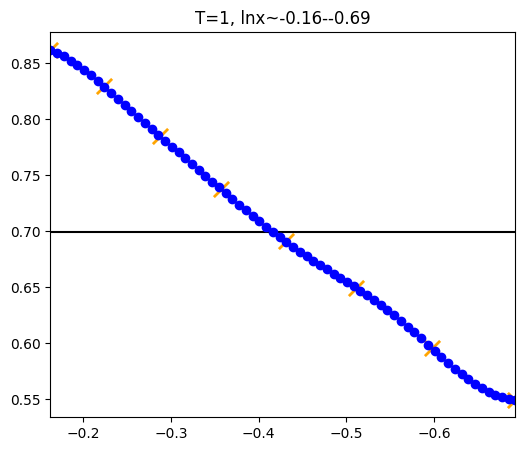

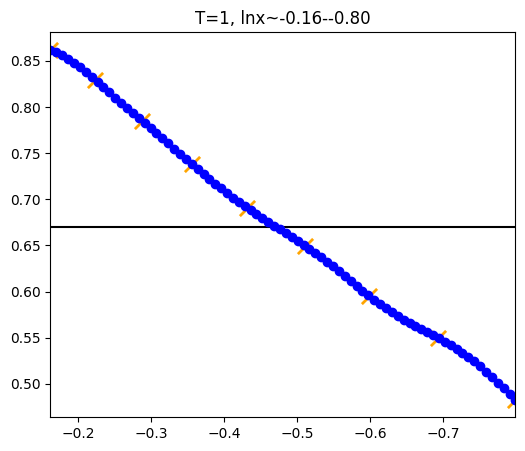

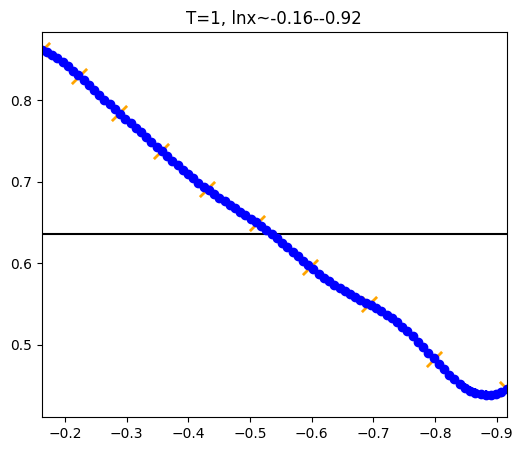

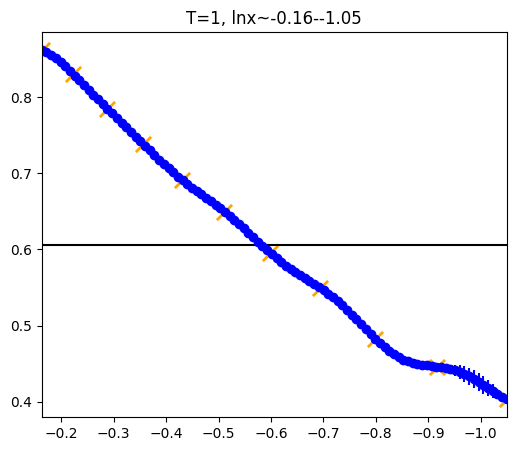

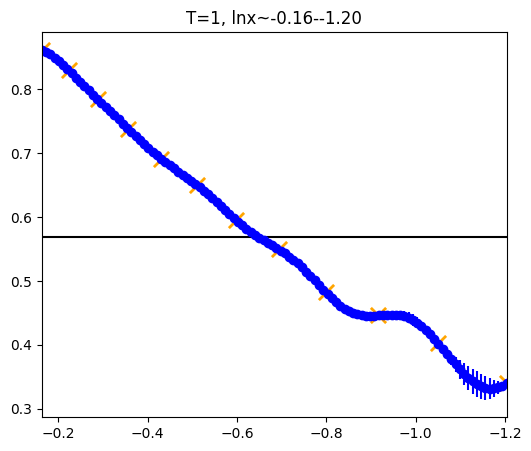

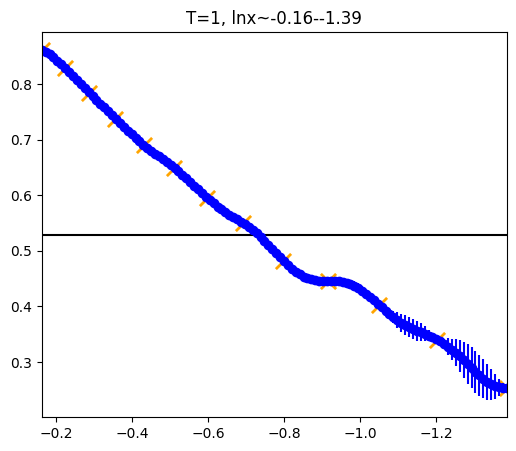

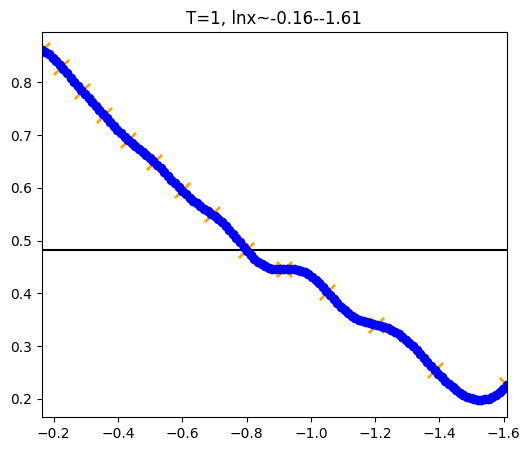

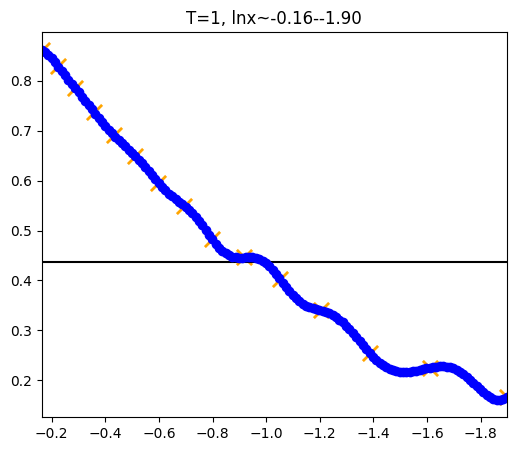

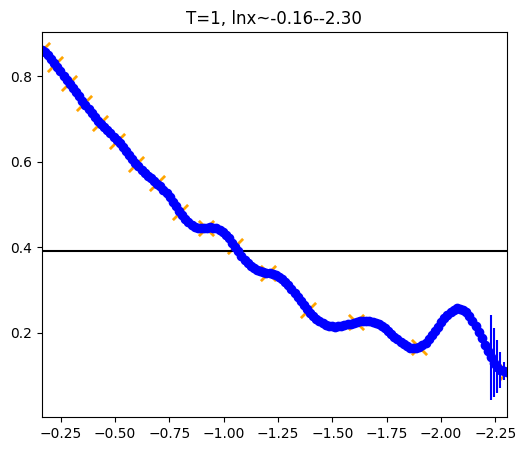

In [18]:

lnx1 = lnx1.reshape(-1)
MCintegral_gp1 = [0]
MCintegral_gp_std1 = [0]
print(x1)
print(lnx1)
print(x)
print(lnx)
for i in range(len(lnx1)-2):
    min_lnx = lnx1[0]
    max_lnx = lnx1[i+1]
    area_lnx = (max_lnx-min_lnx)
    
    MC_x_samples = np.linspace(min_lnx, max_lnx, 10*(i+1))
    mean_Kai = np.mean(Kai_NPT_lnx1_list[idx_T][:i+2])
    kernel = 1.0 * RBF(length_scale=0.05*np.abs(area_lnx))
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(lnx1[:i+2].reshape(-1,1), Kai_NPT_lnx1_list[idx_T][:i+2].reshape(-1,1)-mean_Kai)
    
    MC_y_samples, std_MC_y_samples = gp.predict(MC_x_samples.reshape(-1,1), return_std=True)
    MC_y_samples -= 1.
    MC_y_average = np.mean(MC_y_samples.reshape(-1))
    MC_y_std = np.max(std_MC_y_samples.reshape(-1))/np.sqrt(100*(i+1))
    MCintegral_gp1.append((MC_y_average+mean_Kai)*(area_lnx))
    MCintegral_gp_std1.append(MC_y_std*np.abs(area_lnx))
    plt.figure()
    plt.errorbar(np.linspace(min_lnx, max_lnx, 10*(i+1)), MC_y_samples+mean_Kai, std_MC_y_samples, c="blue", fmt='o', linestyle='None')
    plt.scatter(lnx1[:i+2], Kai_NPT_lnx1_list[idx_T][:i+2]-1, marker="x", c="orange", s=120, linewidths=2)
    plt.axhline(MC_y_average+mean_Kai, c="k")
    plt.xlim((min_lnx, max_lnx))
    plt.title("T=%d, lnx~%.2f-%.2f"%(T, min_lnx, max_lnx))

MCintegral_gp1 = np.array(MCintegral_gp1)
MCintegral_gp_std1 = np.array(MCintegral_gp_std1)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85]
[0.85 0.8  0.75 0.7  0.65 0.6  0.55 0.5  0.45 0.4  0.35 0.3  0.25 0.2
 0.15 0.1  0.05]


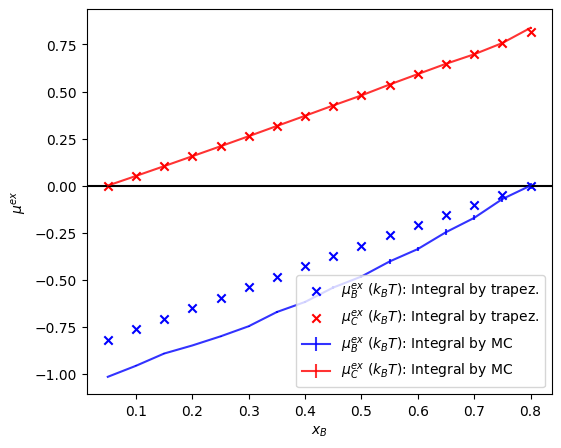

In [19]:
print(x)
print(x1)
plt.scatter(x[:-1], (integral_gp+baseline)-(integral_gp+baseline)[-1], label="$\mu^{ex}_B$ ($k_BT$): Integral by trapez.", c="blue", marker="x")
plt.errorbar(x[:-1], MCintegral_gp-MCintegral_gp[-1], MCintegral_gp_std, color="blue", alpha=0.8, label="$\mu^{ex}_B$ ($k_BT$): Integral by MC")
plt.scatter(x[:-1], (-(integral_gp1+baseline1)+(integral_gp1+baseline1)[0]), label="$\mu^{ex}_C$ ($k_BT$): Integral by trapez.", c="red", marker="x")
plt.errorbar(x[:-1], (-MCintegral_gp1+MCintegral_gp1[0]), (MCintegral_gp_std1), color="red", alpha=0.8, label="$\mu^{ex}_C$ ($k_BT$): Integral by MC")
# plt.fill_between(x[:-1], lowerb_MCintegral_gp, upperb_MCintegral_gp, color="blue", alpha=0.8)
plt.axhline(0, c="k")
plt.ylabel("$\mu^{ex}$")
plt.xlabel("$x_B$")
# plt.ylim((-0.05, 0.05))
plt.legend()

# plt.figure()
# plt.scatter(x[:-1], ((integral_gp1+baseline1)), label="$\mu^{ex}_B$ ($k_BT$): Integral by trapez.", c="red", marker="x")
# plt.errorbar(x[:-1], (MCintegral_gp1), (MCintegral_gp_std1), color="red", alpha=0.8, label="$\mu^{ex}_B$ ($k_BT$): Integral by MC")
# plt.ylim((-0.05, 0.05))

In [20]:
print("4040K to kJ/mol:", 4040./298.*2.074)
print("4040K to eV:", 4040./300.*0.0259)

4040K to kJ/mol: 28.117315436241608
4040K to eV: 0.3487866666666667
